# Clean HPS model with cross-validated subtyping
- take the full sample
- subsample using 10-fold cross-validation
- regress nuisance separately in the train and test fold
- extract subtypes on the train data
- extract weights for these subtypes from the train and test data
- predict easy cases on weights in train data
- predict ASD in test data using train data easy case signature
- report model performance

Other ideas:
- scale train data before nuisance regression
- then apply the fitted scaler to the test data before their nuisance regression?

In [1]:
%matplotlib inline

In [2]:
import os
import re
import sys
import time
import pickle
sys.path.append('/home/surchs/git/HPS')
from hps.predic import high_confidence
from hps.visu import hps_visu
sys.path.append('/home/surchs/git/HPS/examples/')
import warnings
warnings.filterwarnings('ignore')
import visu_demo
import scipy as sp
import patsy as pat
import numpy as np
import pandas as pd
import nibabel as nib
import sklearn as skl
import scipy.io as sio
import seaborn as sbn
import sklearn.metrics as skm
from scipy import cluster as scl
from scipy import stats as spt
from nilearn import plotting as nlp
from matplotlib import pyplot as plt
from sklearn import linear_model as sln
from sklearn import preprocessing as skp
from sklearn.model_selection import StratifiedKFold

In [3]:
n_seed = 20
n_subtypes = 5

In [4]:
# Paths
root_p = '/home/surchs/sim_big'
# Pheno
sample_p = os.path.join(root_p, 'PROJECT/abide_hps/pheno', 'psm_abide1.csv')
# Data
ct_p = os.path.join(root_p, 'PROJECT/abide_hps/ct')
seed_p = os.path.join(root_p, 'PROJECT/abide_hps/seed', 'MIST_{}'.format(n_seed))
mask_p = os.path.join(root_p, 'PROJECT/abide_hps/mask', 'MIST_mask.nii.gz')
label_p = os.path.join(root_p, 'ATLAS/MIST/Parcel_Information', 'MIST_{}.csv'.format(n_seed))
atlas_p = os.path.join(root_p, 'ATLAS/MIST/Parcellations/', 'MIST_{}.nii.gz'.format(n_seed))
# File templates
ct_t = '{}+{:07}_{}+{}_native_rms_rsl_tlaplace_30mm_{}.txt'
sd_t = 'sub_{{}}_mist_{}.npy'.format(n_seed)
# Make a temp save of the model
dump_p = os.path.join(root_p, 'PROJECT/abide_hps/single_dump_mist_{}.p'.format(n_seed))

In [5]:
# Load data
sample = pd.read_csv(sample_p)
sample['DX_CODE'] = sample['DX_GROUP'].replace({'Autism':1, 'Control':0})
label = pd.read_csv(label_p, delimiter=';')

In [6]:
sample.shape

(370, 97)

In [7]:
mask_i = nib.load(mask_p)
mask = mask_i.get_data().astype(bool)
n_vox = np.sum(mask)
atlas = nib.load(atlas_p).get_data()

# Run the CV model

In [8]:
def corr2_coeff(A,B):
    # Rowwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(1)[:,None]
    B_mB = B - B.mean(1)[:,None]

    # Sum of squares across rows
    ssA = (A_mA**2).sum(1);
    ssB = (B_mB**2).sum(1);

    # Finally get corr coeff
    return np.dot(A_mA,B_mB.T)/np.sqrt(np.dot(ssA[:,None],ssB[None]))

In [9]:
def subtype(stack, n_subtypes):
    # Normalize and then get the distance
    norm = skp.scale(stack, axis=1)
    # Get the lower triangle of the distance metric
    dist = sp.spatial.distance.pdist(norm)
    # Build the cluster
    link = scl.hierarchy.linkage(dist, method='ward')
    order = scl.hierarchy.dendrogram(link, no_plot=True)['leaves']
    part = scl.hierarchy.fcluster(link, n_subtypes, criterion='maxclust')
    return order, part, dist

In [10]:
def regress_fc(sample, formula, n_vox, n_seed, seed_p, sd_t):
    n_sub = sample.shape[0]
    resid_seed = np.zeros((n_sub, n_vox, n_seed))
    dmat_seed = pat.dmatrix(formula, data=sample)
    for sid in range(n_seed):
        # Build the regression model for the seed maps
        mod = sln.LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
        sub_seed = np.zeros((n_sub, n_vox))
        # Line index doesn't necessarily match continuous index
        for rid, (rid_abs, row) in enumerate(sample.iterrows()):
            p = os.path.join(seed_p, sd_t.format(row['SUB_ID']))
            d = np.load(p)
            sub_seed[rid, :] = d[sid, ...]
        res = mod.fit(dmat_seed, sub_seed)
        resid = sub_seed - res.predict(dmat_seed)
        resid_seed[..., sid] = resid
    
    return resid_seed

In [11]:
def regress_ct(sample, formula, ct_p, ct_t):
    n_sub = sample.shape[0]
    # Generate the CT residuals
    for rid, (rid_abs, row) in enumerate(sample.iterrows()):
        p_right = os.path.join(ct_p, ct_t.format(row['Site'], row['Subject'], row['Session'], row['Run'], 'right'))
        p_left = os.path.join(ct_p, ct_t.format(row['Site'], row['Subject'], row['Session'], row['Run'], 'left'))
        ct_l = pd.read_csv(p_left, header=None)[0].values
        ct_r = pd.read_csv(p_right, header=None)[0].values
        # Combine left and right
        ct = np.concatenate((ct_l, ct_r))
        if rid==0:
            n_vert = len(ct)
            sub_ct = np.zeros((n_sub, n_vert))
        sub_ct[rid, :] = ct
    dmat_ct = pat.dmatrix(formula, data=sample)
    mod = sln.LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)
    res = mod.fit(dmat_ct, sub_ct)
    resid_ct = sub_ct - res.predict(dmat_ct)
    
    return resid_ct

In [12]:
def make_subtype_fc(resid, n_subtypes=5):
    n_sub, n_vox, n_seed = resid.shape
    # Run the FC subtypes
    weights_fc = np.zeros((n_sub, n_subtypes, n_seed))
    subtypes_fc = np.zeros((n_subtypes,) + resid.shape[1:])
    parts_fc = np.zeros((n_sub, n_seed))
    orders_fc = np.zeros((n_sub, n_seed))
    dists_fc = np.zeros((n_sub, n_sub, n_seed))

    for sid in range(n_seed):
        order_fc, part_fc, dist_fc = subtype(resid[..., sid], n_subtypes)
        dists_fc[..., sid] = sp.spatial.distance.squareform(dist_fc)
        parts_fc[:, sid] = part_fc
        orders_fc[:, sid] = order_fc
        # Make the subtypes
        subtypes_fc_tmp = np.array([np.mean(resid[part_fc==i, :, sid], 0) 
                                    for i in range(1,n_subtypes+1)])
        subtypes_fc[..., sid] = subtypes_fc_tmp
        # Compute the weights
        weights_fc[..., sid] = corr2_coeff(resid[..., sid], subtypes_fc_tmp)
    return subtypes_fc, weights_fc

In [13]:
def make_subtype_ct(resid, n_subtypes):
    order_ct, part_ct, dist_ct = subtype(resid, n_subtypes)
    # Make the subtypes
    subtypes_ct = np.array([np.mean(resid[part_ct==i, :], 0) 
                            for i in range(1,n_subtypes+1)])
    # Compute the weights
    weights_ct = corr2_coeff(resid, subtypes_ct)
    return (subtypes_ct, weights_ct)

In [14]:
def make_weights_fc(subtypes, resid):
    n_sub, n_vox, n_seed = resid.shape
    n_subtypes = subtypes.shape[0]
    weights_fc = np.zeros((n_sub, n_subtypes, n_seed))
    for sid in range(n_seed):
    # Compute the weights
        weights_fc[..., sid] = corr2_coeff(resid[..., sid], subtypes[..., sid])
    return weights_fc

In [15]:
def make_weights_ct(subtypes, resid):
    weights_ct = corr2_coeff(resid, subtypes)
    return weights_ct

In [16]:
# Get the full range of subject indices and clinical labels
sub_indices = sample.index.values
labels = sample['DX_CODE'].values

In [17]:
fc_cols = ['fc_n{}_s{}'.format(nid+1, sid+1) 
           for sid in range(n_subtypes) 
           for nid in range(n_seed)]
fc_col_params = [(nid, sid) for sid in range(n_subtypes) 
                 for nid in range(n_seed)]


ct_cols = ['ct_s{}'.format(sid+1) 
           for sid in range(n_subtypes)]
ct_col_params = [(-1, sid) for sid in range(n_subtypes)]
cols = ct_cols + fc_cols
col_features = ['BV', 'AGE_AT_SCAN', 'FD_scrubbed', ] + cols
col_params = [(None, None)]*3 + ct_col_params + fc_col_params

In [17]:
scores_s1_l = list()
scores_s2_l = list()
y_target_l = list()

start = time.time()
took = []
skf = StratifiedKFold(n_splits=10)
for cv_idx, (train_index, test_index) in enumerate(skf.split(sub_indices, labels)):
    cv_start = time.time()
    
    # Get the train, and test sample
    train_sample = sample.loc[train_index]
    test_sample = sample.loc[test_index]
    n_sub_train = train_sample.shape[0]
    n_sub_test = test_sample.shape[0]
    
    # Replicate the subtyping process
    # Extract the train and test data and regress nuisance factors
    train_resid_fc = regress_fc(train_sample, 
                               'AGE_AT_SCAN + FD_scrubbed + Site', 
                               n_vox, n_seed=n_seed, 
                               seed_p=seed_p, sd_t=sd_t)
    test_resid_fc = regress_fc(test_sample, 
                              'AGE_AT_SCAN + FD_scrubbed + Site', 
                              n_vox, n_seed=n_seed, 
                              seed_p=seed_p, sd_t=sd_t)
    train_resid_ct = regress_ct(train_sample, 'AGE_AT_SCAN + Site', ct_p, ct_t)
    test_resid_ct = regress_ct(test_sample, 'AGE_AT_SCAN + Site', ct_p, ct_t)
    # Make the subtypes from the train data
    (subtypes_fc, train_weights_fc) = make_subtype_fc(train_resid_fc, n_subtypes=n_subtypes)
    (subtypes_ct, train_weights_ct) = make_subtype_ct(train_resid_ct, n_subtypes=n_subtypes)
    # Get the test weights
    test_weights_fc = make_weights_fc(subtypes_fc, test_resid_fc)
    test_weights_ct = make_weights_ct(subtypes_ct, test_resid_ct)
    
    # Build input data
    train_fc = np.reshape(train_weights_fc, (n_sub_train, n_subtypes*n_seed))
    test_fc = np.reshape(test_weights_fc, (n_sub_test, n_subtypes*n_seed))
    train_w = np.concatenate((train_weights_ct, train_fc), 1)
    test_w = np.concatenate((test_weights_ct, test_fc), 1)
    
    # Make sure we use the correct index or else there will be NaNs in the weight columns
    w_data_train = pd.DataFrame(data=train_w, columns=cols, index=train_index)
    data_train = train_sample.join(w_data_train)
    w_data_test = pd.DataFrame(data=test_w, columns=cols, index=test_index)
    data_test = test_sample.join(w_data_test)
    
    # Select the features
    scaler = skl.preprocessing.StandardScaler()
    x_train = data_train.loc[:, col_features]
    # Normalize
    X_train = scaler.fit_transform(x_train)
    # Take the numeric diagnosis code, 0 is control, 1 is autism
    y_train = data_train.loc[:, ['DX_CODE']].values.squeeze()

    # Same for the test data
    x_test = data_test.loc[:, col_features]
    # Normalize, but use the fitted scalar of the training data
    X_test = scaler.transform(x_test)
    y_test = data_test.loc[:, ['DX_CODE']].values.squeeze()
    
    # Train the model
    hps = high_confidence.TwoStagesPrediction(verbose=False,
                                          n_iter=1000,
                                          shuffle_test_split=0.5,
                                            gamma=1,
                                          min_gamma=0.9,
                                          thresh_ratio=0.3)
    hps.fit(X_train, y_train)
    scores, dic_results = hps.predict(X_test)
    scores_s1_l.append(dic_results['s1_hat'])
    scores_s2_l.append(dic_results['s2_hat'])
    y_target_l.append(y_test)
    
    
    
    current_duration = time.time()-cv_start
    took.append(current_duration)
    avg_time = np.mean(took)
    elapsed_time = np.sum(took)
    remaining_time = avg_time * (9-cv_idx)
    
    print('CV fold {} done. Took {:.2f}s ({:.2f}s), {:.2f}s total, {:.2f}s to go.'.format(cv_idx+1,
                                                                              current_duration,
                                                                              avg_time,
                                                                              elapsed_time,
                                                                              remaining_time))

Stage 1
Stage 2
CV fold 1 done. Took 432.16s (432.16s), 432.16s total, 3889.40s to go.
Stage 1
Stage 2
CV fold 2 done. Took 433.22s (432.69s), 865.37s total, 3461.50s to go.
Stage 1
Stage 2
CV fold 3 done. Took 360.21s (408.53s), 1225.59s total, 2859.70s to go.
Stage 1
Stage 2
CV fold 4 done. Took 436.84s (415.61s), 1662.43s total, 2493.64s to go.
Stage 1
Stage 2
CV fold 5 done. Took 384.81s (409.45s), 2047.24s total, 2047.24s to go.
Stage 1
Stage 2
CV fold 6 done. Took 461.10s (418.06s), 2508.34s total, 1672.23s to go.
Stage 1
Stage 2
CV fold 7 done. Took 454.00s (423.19s), 2962.34s total, 1269.57s to go.
Stage 1
Stage 2
CV fold 8 done. Took 291.86s (406.77s), 3254.20s total, 813.55s to go.
Stage 1
Stage 2
CV fold 9 done. Took 384.02s (404.25s), 3638.22s total, 404.25s to go.
Stage 1
Stage 2
CV fold 10 done. Took 302.11s (394.03s), 3940.33s total, 0.00s to go.


In [18]:
y = sample.DX_CODE.values.squeeze()

In [19]:
ohe = skl.preprocessing.OneHotEncoder(sparse=False)
ohe.fit(y.reshape(-1, 1))
labels = ohe.transform(y.reshape(-1, 1))

In [20]:
scores_s1_arr = np.vstack(scores_s1_l)
scores_s2_arr = np.vstack(scores_s2_l)
y_target_arr = np.hstack(y_target_l)

########################
print('##########################')
# S1
y_mb = ohe.transform(y_target_arr[:,np.newaxis])
pred_y_ = scores_s1_arr

print('Stage 1 (BASE)')
hps_visu.print_scores(hps_visu.scores(y_mb, pred_y_))


# S2
y_mb = ohe.transform(y_target_arr[:,np.newaxis])
pred_y_ = scores_s2_arr

print('Stage 2 (HPS)')
hps_visu.print_scores(hps_visu.scores(y_mb, pred_y_)) 
print('##########################')

##########################
Stage 1 (BASE)
Class 0 Precision: 58.70 Specificity: 58.24 Recall: 57.45 N: 184
Class 1 Precision: 56.99 Specificity: 57.45 Recall: 58.24 N: 186
Total Precision: 57.84 Specificity: 57.84 Recall: 57.84 N: 185
Stage 2 (HPS)
Class 0 Precision: 73.33 Specificity: 95.60 Recall: 11.70 N: 30
Class 1 Precision: 85.71 Specificity: 97.87 Recall: 13.19 N: 28
Total Precision: 79.52 Specificity: 96.74 Recall: 12.44 N: 29
##########################


In [21]:
hps_asd = scores_s2_arr[:, 1]==1
hps_con = scores_s2_arr[:, 1]==0
true_asd = y_mb[:, 1]==1
true_con = y_mb[:, 1]==0

In [22]:
sens = np.sum(hps_asd&true_asd)/np.sum(true_asd)

In [23]:
sens

0.13186813186813187

In [24]:
spec = np.sum(true_con[hps_con])/np.sum(true_con)

In [25]:
spec

0.9787234042553191

In [26]:
precision = np.sum(true_asd[hps_asd])/np.sum(hps_asd)

In [27]:
precision

0.8571428571428571

In [28]:
tn, fp, fn, tp = skl.metrics.confusion_matrix(y_mb[:, 1], scores_s2_arr[: , 1]).ravel().astype(float)

In [29]:
p = np.sum(y_mb[:, 1])
n = np.sum(y_mb[:, 0])

In [30]:
tpr = tp/p
fpr = fp/n

fnr = fn/p
tnr = tn/n

In [31]:
tpr/fpr

6.197802197802198

In [32]:
tnr/fnr

1.127390250471317

In [33]:
fpr

0.02127659574468085

In [34]:
tpr

0.13186813186813187

In [35]:
fp

4.0

In [36]:
tp

24.0

In [37]:
fn

158.0

In [38]:
tn

184.0

In [39]:
accuracy = (tp+tn)/(tp+fp+tn+fn)

In [40]:
accuracy

0.5621621621621622

## Train a model on the whole dataset

Loading model from /home/surchs/sim_big/PROJECT/abide_hps/single_dump_mist_20.p


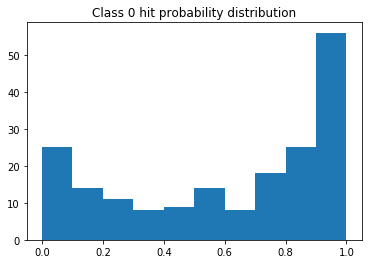

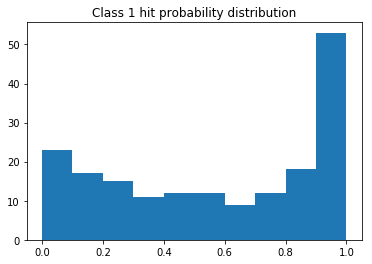

In [18]:
n_sub = sample.shape[0]
n_sub = sample.shape[0]


if not os.path.isfile(dump_p):
    print('Need to Run all')
    # Replicate the subtyping process
    # Extract the train and test data and regress nuisance factors
    resid_fc = regress_fc(sample, 
                               'AGE_AT_SCAN + FD_scrubbed + Site', 
                               n_vox, n_seed=n_seed, 
                               seed_p=seed_p, sd_t=sd_t)
    resid_ct = regress_ct(sample, 'AGE_AT_SCAN + Site', ct_p, ct_t)

    # Make the subtypes from the train data
    (subtypes_fc, weights_fc) = make_subtype_fc(resid_fc, n_subtypes=n_subtypes)
    (subtypes_ct, weights_ct) = make_subtype_ct(resid_ct, n_subtypes=n_subtypes)

    # Build input data
    fc = np.reshape(weights_fc, (n_sub, n_subtypes*n_seed))

    features = np.concatenate((weights_ct, fc), 1)


    # Make sure we use the correct index or else there will be NaNs in the weight columns
    feat_data = pd.DataFrame(data=features, columns=cols)
    data = sample.join(feat_data)

    # Select the features
    scaler = skl.preprocessing.StandardScaler()
    x_ = data.loc[:, col_features]
    # Normalize
    X = scaler.fit_transform(x_)
    # Take the numeric diagnosis code, 0 is control, 1 is autism
    y = data.loc[:, ['DX_CODE']].values.squeeze()

    # Train the model
    hps = high_confidence.TwoStagesPrediction(verbose=False,
                                          n_iter=1000,
                                          shuffle_test_split=0.5,
                                            gamma=1,
                                          min_gamma=0.95,
                                          thresh_ratio=0.3)


    hps.fit(X, y)

    out_dict = {'hps':hps, 'subtypes_fc':subtypes_fc, 'subtypes_ct':subtypes_ct,
                'data':data}
    pickle.dump(out_dict, open(dump_p, 'wb'))
else:
    print('Loading model from {}'.format(dump_p))
    in_dict = pickle.load(open(dump_p, 'rb'))
    hps = in_dict['hps']
    data = in_dict['data']
    subtypes_fc = in_dict['subtypes_fc']
    subtypes_ct = in_dict['subtypes_ct']
    scaler = skl.preprocessing.StandardScaler()
    x_ = data.loc[:, col_features]
    # Normalize
    X = scaler.fit_transform(x_)
    # Take the numeric diagnosis code, 0 is control, 1 is autism
    y = data.loc[:, ['DX_CODE']].values.squeeze()


res_hitproba = hps.training_hit_probability
plt.figure()
plt.title('Class 0 hit probability distribution')
plt.hist(hps.training_hit_probability[y==0],10);
plt.figure()
plt.title('Class 1 hit probability distribution')
plt.hist(hps.training_hit_probability[y==1],10);

In [19]:
hps_base_rate = np.sum(hps.training_hit_probability[y==1]>0.9)/len(hps.training_hit_probability[y==1])

In [20]:
hps_base_rate

0.29120879120879123

In [21]:
hps_base_rate*0.0113

0.0032906593406593406

Assuming that our ASD sample was prevalent, how common would the identified subtype be in a general population sample? Answer: about 0.33% incidence. So not very large indeed. Bot on the other hand, they would make up 1/3 of individuals with ASD. So if we could push the base rate to 10% based on pre-screening or something like that:

In [22]:
hps_base_rate*0.1

0.029120879120879125

We'd already find about 3% of HPS cases in our screening sample. Not that many...

In [23]:
print('HPS base rate {:.2f}%'.format(hps_base_rate*100))

HPS base rate 29.12%


## Review the contributing features

In [24]:
print('hi')

hi


In [25]:
# Get the feature weights of the second stage for class 2 (ASD)
feature_weights = hps.confidencemodel.clfs[1].coef_
non_zero_features = np.where(feature_weights!=0)[1]

In [26]:
# Get only the FC weights
fc_weights = feature_weights[:, 3+n_subtypes:].flatten()
fc_param = [(nid, sid) for nid in range(n_seed) for sid in range(n_subtypes)]
fc_sort = np.argsort(fc_weights)

In [27]:
fc_data = pd.DataFrame({'net':[fc_param[i][0] for i in fc_sort], 
                        'sid':[fc_param[i][1] for i in fc_sort], 
                        'weight':[fc_weights[i] for i in fc_sort],
                        'name':['n_{}_s{}'.format(*fc_param[i]) for i in fc_sort]})

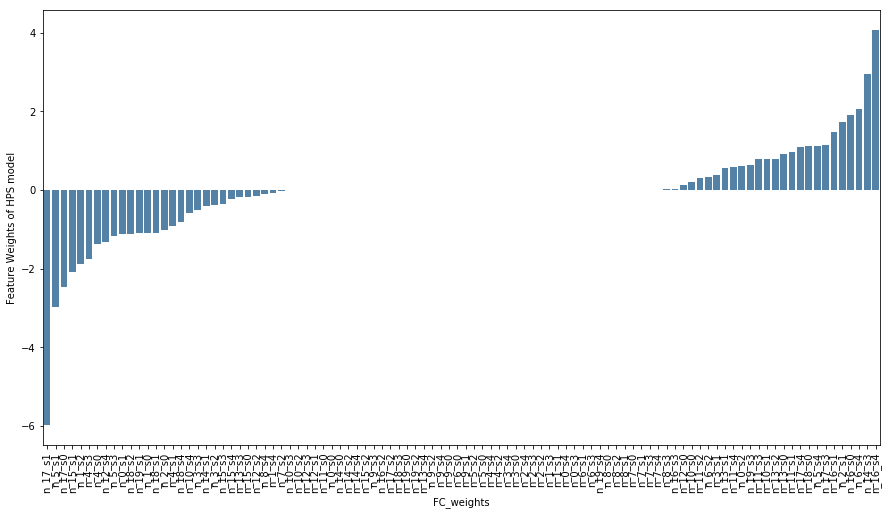

In [28]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(111)
#g = sbn.barplot(x='feature', y='weights', data=weights, hue='feature_type', ax=ax)
g = sbn.barplot(x='name', y='weight', data=fc_data, ax=ax, ci=None, color='steelblue')
g.set(xlabel='FC_weights', ylabel='Feature Weights of HPS model')
plt.xticks(rotation=90);
#f.savefig(features_p, dpi=300, bbox_inches='tight', pad_inches=0)

In [63]:
# How many networks are involved in the bottom 5 features
bottom_net = fc_data.loc[:4]['net'].unique()

In [64]:
# How many networks are involved in the top 5 features
top_net = fc_data.loc[::-1][:5]['net'].unique()

In [65]:
len(set(top_net).union(bottom_net))

8

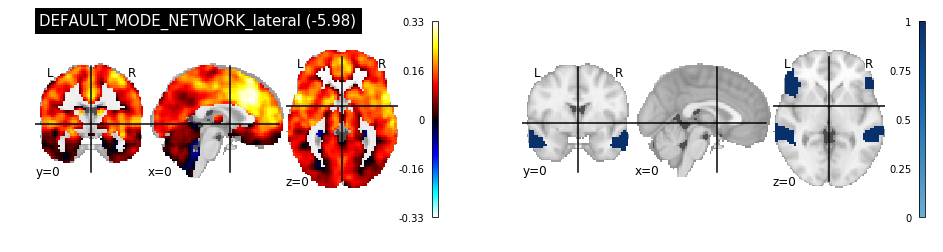

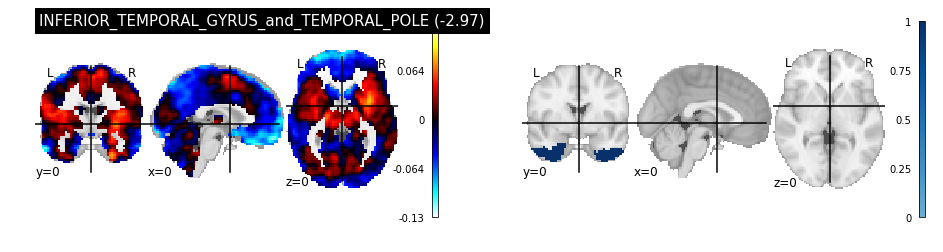

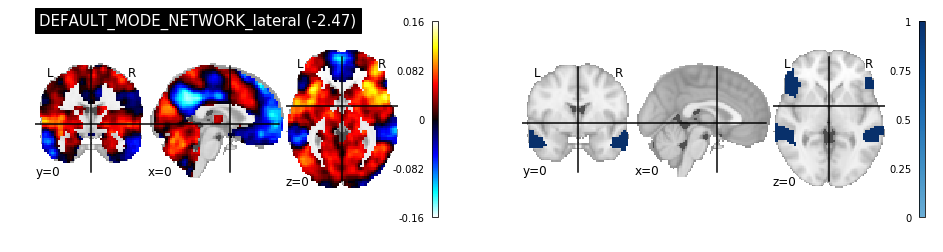

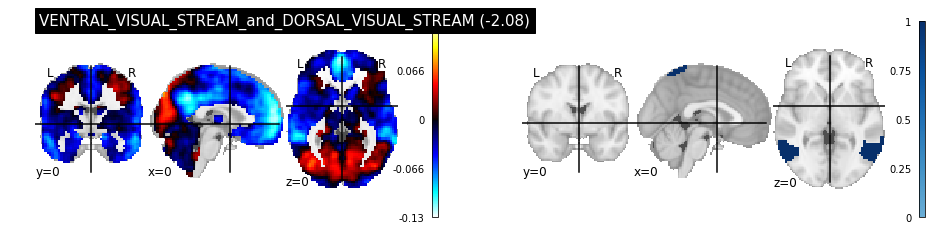

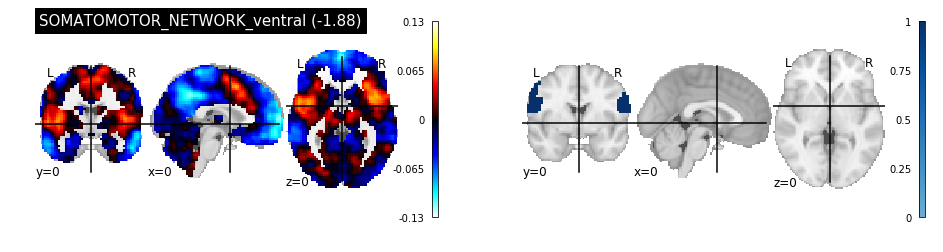

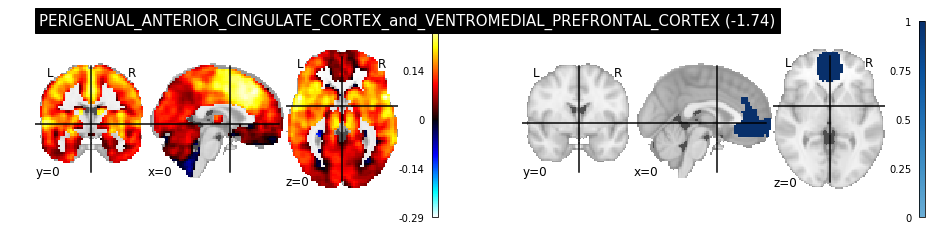

In [29]:
# Show me the top 5 features
for rid, row in fc_data.loc[:5].iterrows():
    f = plt.figure(figsize=(16,4))
    ax1 = f.add_subplot(121) 
    ax2 = f.add_subplot(122)
    # Show me the subtype
    n_name = label.loc[label.roi==row['net']+1].name.values[0]
    vol = np.zeros(mask.shape)
    vol[mask] = subtypes_fc[row['sid'], :, row['net']]
    img = nib.Nifti1Image(vol, affine=mask_i.affine)
    nlp.plot_stat_map(img, title='{} ({:.2f})'.format(n_name, row['weight']), cut_coords=(0,0,0), axes=ax1)
    
    
    a_vol = np.zeros(mask.shape)
    a_vol[atlas==row['net']+1] = 1
    a_img = nib.Nifti1Image(a_vol, affine=mask_i.affine)
    nlp.plot_stat_map(a_img, cut_coords=(0,0,0), axes=ax2, cmap=plt.cm.Blues)

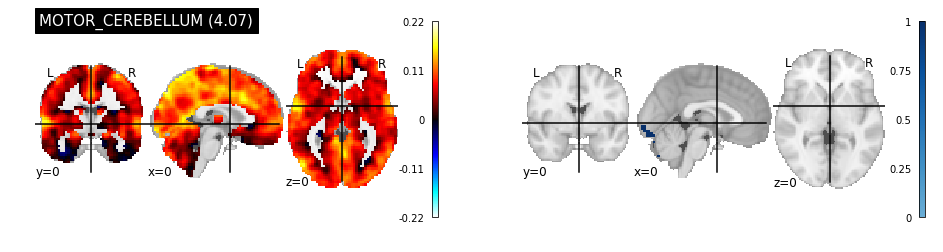

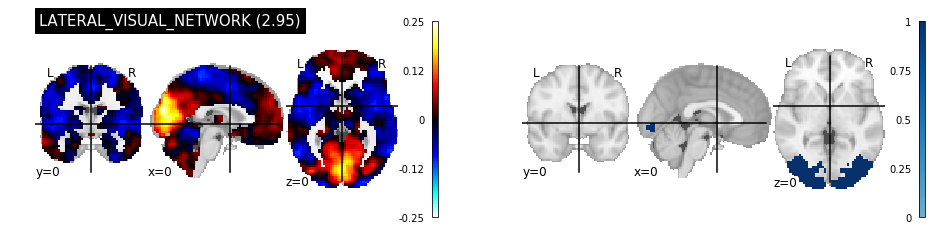

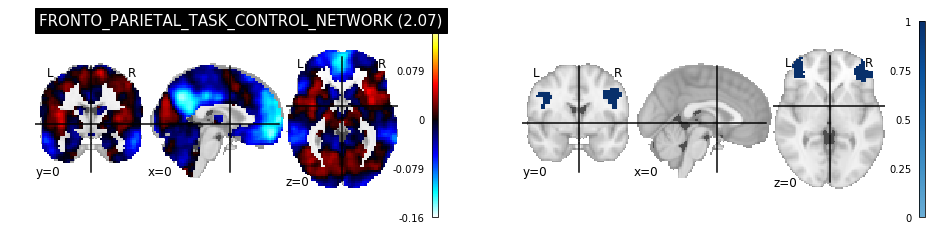

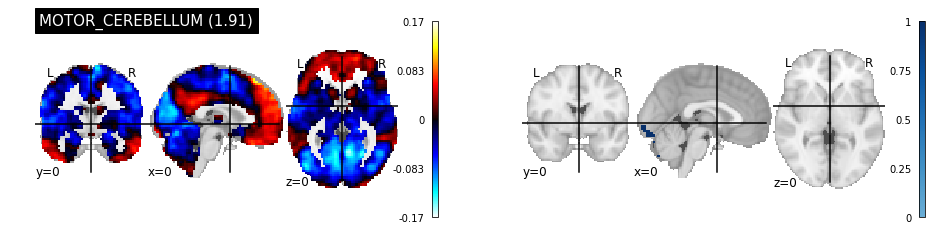

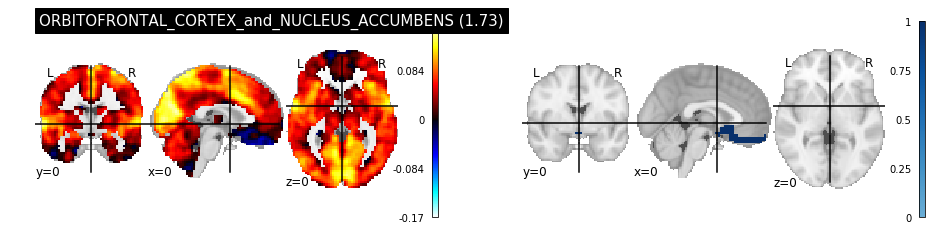

In [30]:
# Show me the top 5 features
for rid, row in fc_data.loc[::-1][:5].iterrows():
    f = plt.figure(figsize=(16,4))
    ax1 = f.add_subplot(121) 
    ax2 = f.add_subplot(122)
    # Show me the subtype
    n_name = label.loc[label.roi==row['net']+1].name.values[0]
    vol = np.zeros(mask.shape)
    vol[mask] = subtypes_fc[row['sid'], :, row['net']]
    img = nib.Nifti1Image(vol, affine=mask_i.affine)
    nlp.plot_stat_map(img, title='{} ({:.2f})'.format(n_name, row['weight']), cut_coords=(0,0,0), axes=ax1)
    
    
    a_vol = np.zeros(mask.shape)
    a_vol[atlas==row['net']+1] = 1
    a_img = nib.Nifti1Image(a_vol, affine=mask_i.affine)
    nlp.plot_stat_map(a_img, cut_coords=(0,0,0), axes=ax2, cmap=plt.cm.Blues)

In [31]:
# Get the feature weights of the second stage for class 2 (ASD)
feature_weights = hps.confidencemodel.clfs[1].coef_
non_zero_features = np.where(feature_weights!=0)[1]

In [32]:
col_nonzero = [col_features[ind] for ind in non_zero_features]

feature_type = list()
for col in col_nonzero:
    if 'ct' in col:
        feature_type.append('Anatomical')
    elif 'fc' in col:
        feature_type.append('Functional')
    else:
        feature_type.append('Phenotype')
data = {'weights':feature_weights[0, non_zero_features],
            'feature':col_nonzero,
            'feature_type':feature_type}
weights = pd.DataFrame(data=data)

In [33]:
fc_nonzero_feature_names = ['fc_n{}_s{}'.format(nid+1, sid+1) for nid in range(n_seed) for sid in range(n_subtypes) 
                            if 'fc_n{}_s{}'.format(nid+1, sid+1) in col_nonzero]
ct_nonzero_feature_names = ['ct_s{}'.format(i) for i in range(1,n_subtypes+1)]
nonzero_feature_names = ['BV', 'AGE_AT_SCAN'] + ct_nonzero_feature_names + fc_nonzero_feature_names
feat_ind = [col_features.index(feat) for feat in nonzero_feature_names]

In [34]:
feature_type = list()
feature_names = list()
for f_name in nonzero_feature_names:
    if 'ct' in f_name:
        feature_type.append('Anatomical')
    elif 'fc' in col:
        feature_type.append('Functional')
    else:
        feature_type.append('Phenotype')
    # Get the real name, yo
    net_s = re.search(r'(?<=fc_n)[0-9]+', f_name)
    sub_s = re.search(r'(?<=_s)[0-9]', f_name)
    if net_s and sub_s:
        net = int(net_s.group())
        net_name = label[label['roi']==net]['label'].values[0]
        sub = int(sub_s.group())
        fc_f_name = 'FC_{}_subtype_{}'.format(net_name, sub)
        feature_names.append(fc_f_name)
    elif sub_s and 'ct' in col:
        sub = int(sub_s.group())
        ct_f_name = 'CT_subtype_{}'.format(sub)
        feature_names.append(ct_f_name)
    else:
        feature_names.append(f_name)
        
data_annotated = {'weights':feature_weights[0, feat_ind],
            'feature':feature_names,
            'feature_type':feature_type}
features_annotated = pd.DataFrame(data=data_annotated)

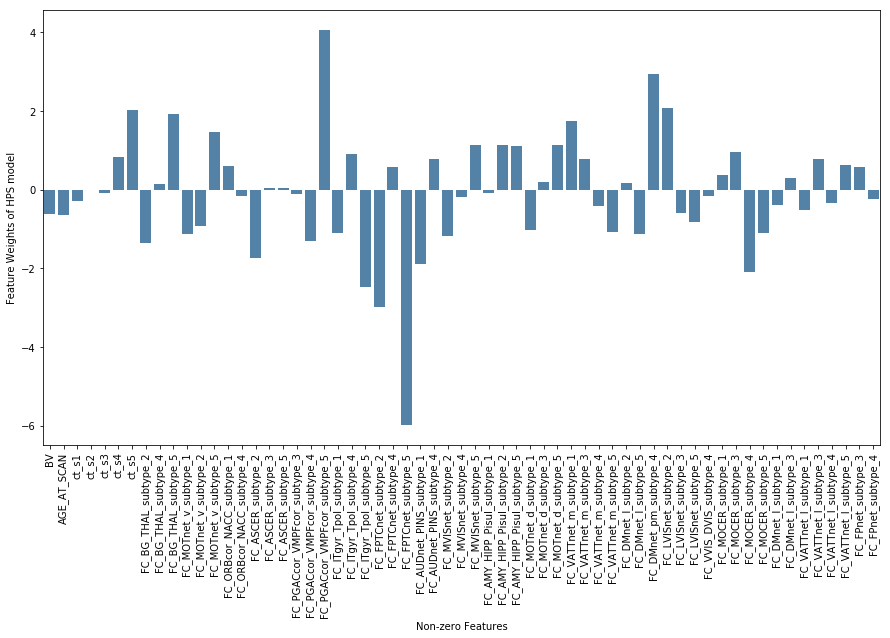

In [35]:
f = plt.figure(figsize=(15,8))
ax = f.add_subplot(111)
#g = sbn.barplot(x='feature', y='weights', data=weights, hue='feature_type', ax=ax)
g = sbn.barplot(x='feature', y='weights', data=features_annotated, ax=ax, ci=None, color='steelblue')
g.set(xlabel='Non-zero Features', ylabel='Feature Weights of HPS model')
plt.xticks(rotation=90);
#f.savefig(features_p, dpi=300, bbox_inches='tight', pad_inches=0)

In [36]:
subtypes_fc.shape

(5, 57790, 20)

## Which are the features that are not zero

In [37]:
non_zero_features

array([  0,   1,   2,   3,   5,   6,   7,   9,  10,  13,  15,  17,  18,
        19,  24,  25,  26,  28,  29,  31,  34,  36,  37,  40,  42,  45,
        51,  52,  58,  59,  62,  64,  65,  66,  67,  68,  70,  72,  73,
        74,  75,  76,  79,  81,  83,  84,  86,  87,  88,  89,  91,  92,
        93,  94,  96,  97,  98,  99, 100, 102, 104, 106])

In [38]:
# Most positive feature
pos_idx = np.argmax(feature_weights)
pos_name = col_features[pos_idx]
pos_params = col_params[pos_idx]

neg_idx = np.argmin(feature_weights)
neg_name = col_features[neg_idx]
neg_params = col_params[neg_idx]

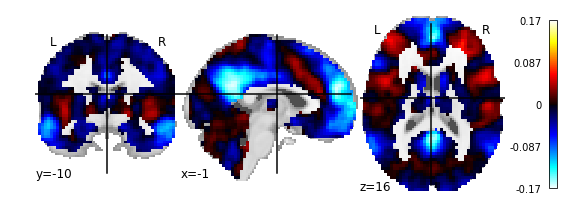

In [39]:
# Show me the subtype
pos_vol = np.zeros(mask.shape)
pos_vol[mask] = subtypes_fc[pos_params[1], :, pos_params[0]]
pos_img = nib.Nifti1Image(pos_vol, affine=mask_i.affine)
nlp.plot_stat_map(pos_img)

In [40]:
def show_fc_feature(sbt_arr, sid, nid, mask):
    # Show me the subtype
    vol = np.zeros(mask.shape)
    vol[mask] = sbt_arr[sid, :, nid]
    img = nib.Nifti1Image(vol, affine=mask_i.affine)
    nlp.plot_stat_map(img)

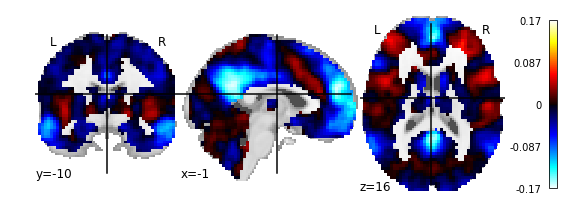

In [41]:
show_fc_feature(subtypes_fc, pos_params[1], pos_params[0], mask)

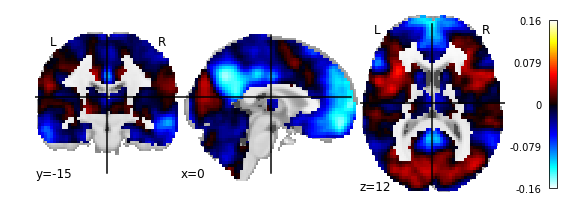

In [42]:
show_fc_feature(subtypes_fc, neg_params[1], neg_params[0], mask)

They look very similar but they are from different seed regions

In [43]:
sort_idx = np.argsort(feature_weights).flatten()

## Make the average positive feature (first 10)

In [44]:
for i in sort_idx[:10]:
    print(col_params[i])

(6, 4)
(6, 1)
(5, 4)
(16, 3)
(7, 0)
(3, 1)
(0, 1)
(4, 3)
(8, 1)
(1, 0)


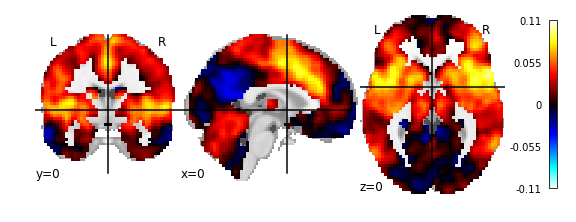

In [45]:
pos_feat = np.zeros(subtypes_fc.shape[1])
q = 0
for i in sort_idx[-3:]:
    tmp = col_params[i]
    if feature_weights[:, i]<0:
        continue
    if tmp[0] is None:
        continue
    if tmp[0]<0:
        continue
    pos_feat += subtypes_fc[tmp[1], :, tmp[0]]
    q+=1
pos_feat = pos_feat/q


pos_vol = np.zeros(mask.shape)
pos_vol[mask] = pos_feat
pos_img = nib.Nifti1Image(pos_vol, affine=mask_i.affine)
nlp.plot_stat_map(pos_img, cut_coords=(0,0,0))

In [46]:
feature_weights.shape

(1, 108)

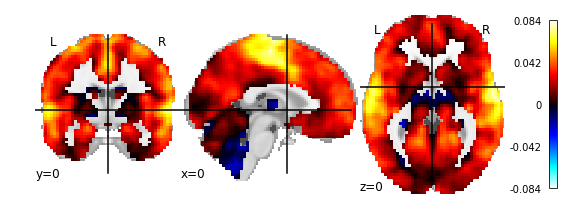

In [47]:
neg_feat = np.zeros(subtypes_fc.shape[1])
q = 0
for i in sort_idx[:10]:
    tmp = col_params[i]
    if feature_weights[:, i]>0:
        continue
    if tmp[0] is None:
        continue
    if tmp[0]<0:
        continue
    neg_feat += subtypes_fc[tmp[1], :, tmp[0]]
    q+=1
neg_feat = neg_feat/q


neg_vol = np.zeros(mask.shape)
neg_vol[mask] = neg_feat
neg_img = nib.Nifti1Image(neg_vol, affine=mask_i.affine)
nlp.plot_stat_map(neg_img, cut_coords=(0,0,0))

## Correlate all FC features and sort them by influence

In [48]:
fc_idx = np.zeros(feature_weights.shape[1]).astype(bool)
fc_idx[-(n_subtypes*n_seed):] = True
# Get the top FC features
fc_weights = feature_weights.flatten()[fc_idx]
fc_sort = np.argsort(fc_weights)


In [49]:
fc_feat = np.array([subtypes_fc[sid, :, nid]
                    for sid in range(n_subtypes) 
                    for nid in range(n_seed)])
fc_sim = np.corrcoef(fc_feat)

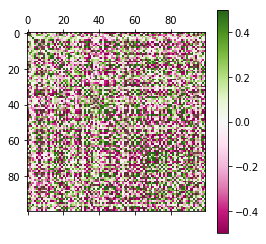

In [50]:
plt.matshow(fc_sim[fc_sort, :][:, fc_sort], vmin=-0.5, vmax=0.5, cmap=plt.cm.PiYG)
plt.colorbar()

There is nothing in there. Maybe at the extremes, but not like this

## Attempt a validation

In [51]:
y = sample.DX_CODE.values.squeeze()
ohe = skl.preprocessing.OneHotEncoder(sparse=False)
ohe.fit(y.reshape(-1, 1))
labels = ohe.transform(y.reshape(-1, 1))

In [52]:
# Load data
validation_p = os.path.join(root_p, 'pheno', 'validation_abide1.csv')
validation = pd.read_csv(validation_p)
validation['DX_CODE'] = validation['DX_GROUP'].replace({'Autism':1, 'Control':0})
n_sub_valid = validation.shape[0]

FileNotFoundError: File b'/home/surchs/sim_big/pheno/validation_abide1.csv' does not exist

In [ ]:
valid_resid_fc = regress_fc(validation, 
                            'AGE_AT_SCAN + FD_scrubbed + Site', 
                            n_vox, n_seed=n_seed, 
                            seed_p=seed_p, sd_t=sd_t)
valid_resid_ct = regress_ct(validation, 'AGE_AT_SCAN + Site', ct_p, ct_t)
valid_weights_fc = make_weights_fc(subtypes_fc, valid_resid_fc)
valid_weights_ct = make_weights_ct(subtypes_ct, valid_resid_ct)

valid_fc = np.reshape(valid_weights_fc, (n_sub_valid, n_subtypes*n_seed))
valid_w = np.concatenate((valid_weights_ct, valid_fc), 1)

w_data_valid = pd.DataFrame(data=valid_w, columns=cols)
data_valid = validation.join(w_data_valid)

In [ ]:
x_valid = data_valid.loc[:, col_features]
X_valid = scaler.transform(x_valid)
y_valid = data_valid.loc[:, ['DX_CODE']].values.squeeze()

scores_valid, dic_results_valid = hps.predict(X_valid)

In [ ]:
scores_s1_valid = dic_results_valid['s1_hat']
scores_s2_valid = dic_results_valid['s2_hat']

In [ ]:
########################
print('##########################')
# S1
y_mb_valid = ohe.transform(y_valid[:,np.newaxis])
pred_y_valid = scores_s1_valid

print('Stage 1 (BASE)')
hps_visu.print_scores(hps_visu.scores(y_mb_valid, pred_y_valid))


# S2
y_mb = ohe.transform(y_valid[:,np.newaxis])
pred_y_valid = scores_s2_valid

print('Stage 2 (HPS)')
hps_visu.print_scores(hps_visu.scores(y_mb_valid, pred_y_valid)) 
print('##########################')

Well, that isn't so amazing now, is it? But it's also not worlds apart in terms of specificity. I mean the precision suffers greatly and overall the model doesn't appear that nice anymore. But it's not so horrible now.

In [ ]:
tn, fp, fn, tp = skl.metrics.confusion_matrix(y_mb_valid[:, 1], scores_s2_valid[: , 1]).ravel().astype(float)

In [ ]:
tp

In [ ]:
fp

In [ ]:
tn

In [ ]:
fn

## Tell me something about these guys

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
HPS_ind_valid = pred_y_valid[:, 1]==1

In [ ]:
# Give me three classes here
asd_hps_valid = [True if HPS_ind_valid[rid]==1 and row['DX_GROUP']=='Autism' else False for rid, row in validation.iterrows()]
asd_ns_valid = [True if HPS_ind_valid[rid]==0 and row['DX_GROUP']=='Autism' else False for rid, row in validation.iterrows()]
tdc_hps_valid = [True if HPS_ind_valid[rid]==1 and row['DX_GROUP']=='Control' else False for rid, row in validation.iterrows()]
tdc_ns_valid = [True if HPS_ind_valid[rid]==0 and row['DX_GROUP']=='Control' else False for rid, row in validation.iterrows()]
group = list()
for rid, row in validation.iterrows():
    if asd_hps_valid[rid]:
        group.append('ASD_HPS')
    elif asd_ns_valid[rid]:
        group.append('ASD_NS')
    elif tdc_hps_valid[rid]:
        group.append('TDC_HPS')
    else:
        group.append('TDC_NS')
results_validation = validation.copy()
results_validation['Group'] = group
# Remove missing values
results_validation.replace({col:{-9999:None} for col in results_validation.columns}, inplace=True)

In [ ]:
sbn.barplot(x='Group', y='AGE_AT_SCAN', data=results_validation)

In [ ]:
sbn.barplot(x='Group', y='BV', data=results_validation)

In [ ]:
sbn.barplot(x='Group', y='FD_scrubbed', data=results_validation)

In [ ]:
sbn.barplot(x='Group', y='FIQ', data=results_validation)

In [ ]:
y_pred = scores_s2_arr
HPS_ind = y_pred[:, 1]==1

In [ ]:
# Give me three classes here
asd_hps = [True if HPS_ind[rid]==1 and row['DX_GROUP']=='Autism' else False for rid, row in sample.iterrows()]
asd_ns = [True if HPS_ind[rid]==0 and row['DX_GROUP']=='Autism' else False for rid, row in sample.iterrows()]
tdc = [True if row['DX_GROUP']=='Control' else False for rid, row in sample.iterrows()]
group = list()
for rid, row in sample.iterrows():
    if asd_hps[rid]:
        group.append('ASD_HPS')
    elif asd_ns[rid]:
        group.append('ASD_NS')
    else:
        group.append('TDC')
results = sample.copy()
results['Group'] = group
# Remove missing values
results.replace({col:{-9999:None} for col in results.columns}, inplace=True)

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [ ]:
sbn.barplot(x='Group', y='AGE_AT_SCAN', data=results)

In [ ]:
lm = ols('AGE_AT_SCAN ~ Group',
               data=results).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

In [ ]:
sbn.barplot(x='Group', y='BV', data=results)

In [ ]:
lm = ols('BV ~ Group',
               data=results).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

In [ ]:
sbn.barplot(x='Group', y='FD_scrubbed', data=results)

In [ ]:
lm = ols('FD_scrubbed ~ Group',
               data=results).fit()
table = sm.stats.anova_lm(lm, typ=2)
table

In [ ]:
sbn.barplot(x='Group', y='FIQ', data=results)

In [ ]:
sbn.barplot(x='Group', y='VIQ', data=results)

In [ ]:
sbn.barplot(x='Group', y='PIQ', data=results)

In [ ]:
sbn.barplot(x='Group', y='SRS_RAW_TOTAL', data=results)

In [ ]:
sbn.barplot(x='Group', y='Gotham_Severity', data=results)

In [ ]:
sbn.barplot(x='Group', y='HANDEDNESS_SCORES', data=results)

In [ ]:
f = plt.figure(figsize=(18, 6))
ax1 = f.add_subplot(131)
ax2 = f.add_subplot(132)
ax3 = f.add_subplot(133)
for rid, g in enumerate(results.groupby('Group')):
    ax = f.add_subplot(1,3,rid+1)
    g[1]['DSM_IV_TR'].value_counts().plot.pie(ax=ax)
    ax.set_title(g[0])